In [1]:
# import dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
import os
from gensim.matutils import kullback_leibler, jaccard, hellinger, jensen_shannon
import logging
import warnings
warnings.filterwarnings('ignore')

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
print('Downloads Complete')

Downloads Complete


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/xijieguo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xijieguo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/xijieguo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def initial_clean(text):
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

def pos(word):
    return nltk.pos_tag([word])[0][1]

informative_pos = ('JJ','VB', 'NN','RBS','VBP','IN','RBR','JJR','JJS','PDT','RP','UH','FW','NNS','VBN','VBG')

def remove_uninformative_pos(text):
    tagged_words = nltk.pos_tag(text)
    return [word for word, tag in tagged_words if tag in informative_pos]
  
clutter = ['food','place','good','order','great','like',
           'service','time','go','ordered','get','love',
           'best','come','eat','dont','tried','try','ask',
           'nice','restaurant','ive','im','didnt']

def remove_garbage(text):
    return [word for word in text if word not in clutter]

def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    return stem_words(remove_garbage(remove_uninformative_pos(remove_stop_words(initial_clean(text)))))

def get_top_k_words(df, k = 10000):
    # first get a list of all words
    all_words = [word for item in list(df['tokenized']) for word in item]
    
    # use nltk fdist to get a frequency distribution of all words
    fdist = FreqDist(all_words)
    
    # define a function only to keep words in the top k words
    top_k_words, _ = zip(*fdist.most_common(k))
    top_k_words = set(top_k_words)
    
    return top_k_words

def keep_top_k_words(text, *top_k_words):
    return [word for word in text if word in top_k_words]

def transform_dataset(df):
    # format the columns
    df = df.groupby(['business_id', 'name'])['text'].apply(' '.join).reset_index()
    df = df[df['text'].map(type) == str]
    df.dropna(axis=0, inplace=True, subset=['text'])
    return df

def gen_tokenized_column(df):
    # preprocess the text and business name and create new column "tokenized"
    df['tokenized'] = df['text'].apply(apply_all)
    top_k_words = get_top_k_words(df)
    df['tokenized'] = df['tokenized'].apply(keep_top_k_words, args=(top_k_words))
    return df

def preprocess_dataset(df):
    t1 = time.time()
    preprocessed_df = gen_tokenized_column(transform_dataset(df))
    t2 = time.time()
    print("Time to clean and tokenize", len(df), "businesses' reviews:", (t2-t1)/60, "min")
    return preprocessed_df
    
def get_coherence_score(model, texts, dictionary):
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

def get_dictionary_corpus(data, no_below=20, no_above=0.5):
    dictionary = corpora.Dictionary(data)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    corpus = [dictionary.doc2bow(doc) for doc in data]
    return dictionary, corpus

def get_perplexity(model, corpus):
    # a measure of how good the model is; lower the better
    return lda_model.log_perplexity(corpus)

def train_lda(corpus, id2word, chunksize=2000, num_topics=12, alpha='auto', eta='auto', passes=1, iterations=50,
              minimum_probability=0.01, eval_every=10, random_state=None):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    """
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, alpha=alpha, eta=eta, 
                   chunksize=chunksize, minimum_probability=minimum_probability, passes=passes, 
                   iterations=iterations, eval_every=eval_every, random_state=random_state)
    
    t2 = time.time()
    print("Time to train LDA model on businesses: ", (t2-t1)/60, "min")
    
    return lda

def train_hdp(corpus, id2word, chunksize=2000, T=150, random_state=None):
    """
    This function trains the hdp model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    """
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    hdp = HdpModel(corpus=corpus, id2word=id2word, T=T, chunksize=chunksize, random_state=random_state)
    t2 = time.time()
    print("Time to train HDP model on businesses: ", (t2-t1)/60, "min")
    
    return hdp

def train_lsi(corpus, id2word, num_topics=12, chunksize=2000, onepass=True, power_iters=2, extra_samples=100):
    """
    This function trains the lsi model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    """
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lsi = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, chunksize=chunksize)
    t2 = time.time()
    print("Time to train LSI model on businesses: ", (t2-t1)/60, "min")
    
    return lsi

def get_most_similar_documents(query, corpus, dictionary, k=10):
    distances = []
    for c in corpus:
        distances.append(kullback_leibler(query, c, num_features=len(dictionary)))
    
    indices = np.array(distances).argsort()[:k]
    return indices

def get_topic_dist(model, corpus):
    doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in model[corpus]])
    return doc_topic_dist

def get_most_similar_businesses(query_data, corpus, dictionary, model):
    query_bow = dictionary.doc2bow(query_data)
    most_sim_ids = get_most_similar_documents(model[query_bow], model[corpus], dictionary)
    return most_sim_ids 


In [5]:
csv_name = 'mesa_5000.csv'
query = pd.read_csv(csv_name, index_col=0)
query = query.loc[query['name']=="Alessia's Ristorante Italiano"]
query['tokenized'] = query['tokenized'].apply(eval)

df = pd.read_csv('mesa_5000.csv', index_col=0)
df['tokenized'] = df['tokenized'].apply(eval)
dictionary, corpus = get_dictionary_corpus(df['tokenized'])

lsi_model = train_hdp(corpus=corpus, id2word=dictionary, T=12)
lsi_model[corpus][0]
query_bow = lsi_model.id2word.doc2bow(query.iloc[0]['tokenized'])

most_sim_ids = get_most_similar_businesses(query.iloc[0]['tokenized'], corpus, dictionary, lsi_model)
tmp = df.iloc[most_sim_ids,:]
tmp

Time to train HDP model on businesses:  0.007100733121236166 min


,business_id,name,latitude,longitude,address,stars,text,tokenized
89,IXUwuNjy707wJNW2U4sRVg,Alessia's Ristorante Italiano,33.436137,-111.716897,5251 E Brown Rd,4.5,I like Italian food. It's probably the only fo...,"[like, italian, food, food, take, home, left, ..."
225,pkEYhukWbbnvfhcx5B_qmg,Seafood Market and Restaurant,33.379451,-111.757781,3406 E Baseline Rd,3.0,We moved to AZ a few years ago and don't know ...,"[move, year, know, mani, seafood, restaur, pre..."
128,ShYv4mmgNwrStaFnje3uZQ,SaDec Bistro,33.321093,-111.685216,"5221 S Power Rd, Are 104",4.0,"I came here for lunch one day, and tried the P...","[lunch, day, pho, bun, bo, hue, substitut, egg..."
160,_myTPlWa8QRN5eavs-hNPg,Pacino's Italian,33.466853,-111.682591,2831 N Power Rd,3.5,We went last Saturday night and it was awesome...,"[last, saturday, night, awesom, place, live, m..."
105,NlymcSxDnjtCLyGvmMoyFg,Aloha Kitchen,33.360701,-111.859793,"2950 S Alma School Rd, Ste 12",4.5,So delicious! My family has been coming here f...,"[delici, famili, come, year, husband, favorit,..."
25,3dw6xhzG08htY5HcL2OjeA,Angry Crab Shack,33.364147,-111.655685,8253 E Guadalupe Rd,3.5,"Been here at least a dozen times, while the se...","[least, dozen, time, servic, poor, food, good,..."
86,HnpV9DkAV3dF88XgalLFbQ,Pho Viet Nam #2,33.434528,-111.719609,"1042 N Higley Rd, Ste 103",4.0,"Very nice restaurant, service is always great!...","[nice, restaur, servic, great, choic, asian, c..."
44,9_HgBRUXUg_vKjTT-GSulA,Golden Hawaiian BBQ,33.393803,-111.868805,"1720 W Southern Ave, Ste C3",4.0,I had always heard great things and finally de...,"[great, thing, tri, chicken, katsu, amaz, gold..."
143,VxgjMl8tQrT4idJW_z8daA,Carrabba's Italian Grill,33.384757,-111.679534,1740 S Clearview Ave,4.0,Yay for Carrabbas...after a bad experience wit...,"[bad, experi, tri, get, outback, next, door, c..."
64,DgZ-pZUo3drzpiCDlDr9IQ,unPhogettable,33.412909,-111.875826,"66 S Dobson Rd, Ste 138",4.0,I ordered a rare beef pho with added beef ball...,"[order, rare, beef, pho, beef, ball, beef, che..."


In [54]:
# Find optimal number of topics by computing coherence score for LDA
def select_num_topics_LDA(dictionary, corpus, texts, end, label, start=3, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    end : Max num of topics
    start: Min num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    model_list = []
    coherence_values = []

    for num_topics in range(start, end + 1, step):
        model = train_lda(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        print('progress: num of topics: ', num_topics)
    
    plt.plot(range(start, end + 1, step), coherence_values)
    plt.title('LDA coherence values on different number of topics')
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(loc='best')
    plt.savefig('lda' + label + '.png')

    return model_list, coherence_values


In [ ]:

def select_num_topics_HDP(dictionary, corpus, texts, end, label, start=3, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    end : Max num of topics
    start: Min num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the HDP model with respective number of topics
    """
    

    coherence_values = []
    model_list = []
    
    for num_topics in range(start, end + 1, step): 
        model = train_hdp(corpus=corpus, id2word=dictionary, T=num_topics, random_state=0)
        model_list.append(model)
        
        topics = []
        for topic_id, topic in model.show_topics(num_topics=num_topics, formatted=False):
            topic = [word for word, _ in topic]
            topics.append(topic)
            
        coherence_model = CoherenceModel(topics=topics, model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        print('progress: num of topics: ', num_topics)
    
    plt.plot(range(start, end + 1, step), coherence_values)
    plt.title('HDP coherence values on different number of topics')
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(loc='best')
    plt.savefig('hdp' + label + '.png')

    return model, coherence_values


In [ ]:
# Find optimal number of topics by computing coherence score for LSI
def select_num_topics_LSI(dictionary, corpus, texts, end, label, start=3, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    end : Max num of topics
    start: Min num of topics

    Returns:
    -------
    model_list : List of LSI topic models
    coherence_values : Coherence values corresponding to the Lsi model with respective number of topics
    """
    
    model_list = []
    coherence_values = []

    for num_topics in range(start, end + 1, step):
        model = train_lsi(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        
        topics = []
        for topic_id, topic in model.show_topics(num_topics=num_topics, formatted=False):
            topic = [word for word, _ in topic]
            topics.append(topic)

        coherence_model = CoherenceModel(topics=topics, model=model, texts=texts, dictionary=dictionary, 
                                         coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        print('progress: num of topics: ', num_topics)
    
    plt.plot(range(start, end + 1, step), coherence_values)
    plt.title('LSI coherence values on different number of topics')
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(loc='best')
    plt.savefig('lsi' + label + '.png')

    return model_list, coherence_values


In [ ]:
# Tune hyperparameter top_k_words parameter num_topics
def eval_top_k_words():
    for fn in ('mesa_5000.csv', 'mesa_7500.csv', 'mesa_10000.csv'):
        df = pd.read_csv(fn, index_col=0)
        df['tokenized'] = df['tokenized'].apply(eval)
        dictionary, corpus = get_dictionary_corpus(df['tokenized'])
        print('preprocessing ' + fn + ' finished')
        select_num_topics_LDA(dictionary=dictionary, corpus=corpus, texts=df['tokenized'], end=30, label=fn)
        select_num_topics_HDP(dictionary=dictionary, corpus=corpus, texts=df['tokenized'], end=30, label=fn)
        select_num_topics_LSI(dictionary=dictionary, corpus=corpus, texts=df['tokenized'], end=30, label=fn)
        print('computing ' + fn + ' finished')
        
eval_top_k_words()


In [3]:
# csv_name = 'mesa_5000'
# df = pd.read_csv(csv_name, index_col=0)
# df['tokenized'] = df['tokenized'].apply(eval)
# dictionary, corpus = get_dictionary_corpus(df['tokenized'])

# Set onepass=False, tune power_iters parameter for LSI model
def tune_power_iters(dictionary, corpus, num_topics, texts):
    
    model_list = []
    coherence_values = []
    
    for num_iter in range(3, 31, 3):
        model = train_lsi(corpus=corpus, id2word=dictionary, num_topics=num_topics, onepass=False, 
                          power_iters=num_iter)
        model_list.append(model)
        
        topics = []
        for topic_id, topic in model.show_topics(num_topics=num_topics, formatted=False):
            topic = [word for word, _ in topic]
            topics.append(topic)

        coherence_model = CoherenceModel(topics=topics, model=model, texts=texts, dictionary=dictionary, 
                                         coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    plt.plot(range(3, 31, 3), coherence_values)
    plt.title('LSI power_iters parameter experiment')
    plt.xlabel("Num of iterations")
    plt.ylabel("Coherence score")
    plt.legend(loc='best')
    plt.savefig('lsi_num_iters.png')
        
    return model_list, coherence_values

df = pd.read_csv('mesa_5000.csv', index_col=0)
df['tokenized'] = df['tokenized'].apply(eval)
dictionary, corpus = get_dictionary_corpus(df['tokenized'])
tune_power_iters(dictionary, corpus, num_topics=12, texts=df['tokenized'])

In [ ]:
# Set onepass=False, tune extra_samples parameter for LSI model
def tune_extra_samples(dictionary, corpus, num_topics, num_iter, texts):
    
    model_list = []
    coherence_values = []
    
    for num_sample in range(100, 300, 30):
        model = train_lsi(corpus=corpus, id2word=dictionary, num_topics=num_topics, onepass=False, 
                          power_iters=num_iter, extra_samples=num_sample)
        model_list.append(model)
        
        topics = []
        for topic_id, topic in model.show_topics(num_topics=num_topics, formatted=False):
            topic = [word for word, _ in topic]
            topics.append(topic)

        coherence_model = CoherenceModel(topics=topics, model=model, texts=texts, dictionary=dictionary, 
                                         coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    plt.plot(range(100, 300, 30), coherence_values)
    plt.title('LSI extra_samples parameter experiment')
    plt.xlabel("Num of extra samples")
    plt.ylabel("Coherence score")
    plt.legend(loc='best')
    plt.savefig('lsi_extra_samples.png')
    
    return model_list, coherence_values

df = pd.read_csv('mesa_5000.csv', index_col=0)
df['tokenized'] = df['tokenized'].apply(eval)
dictionary, corpus = get_dictionary_corpus(df['tokenized'])
tune_extra_samples(dictionary, corpus, num_topics=12, num_iter=50, texts=df['tokenized'])

In [7]:
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

passes = list(range(10, 51, 10))
iterations = list(range(100, 410, 60))

# Set eval_every to 1 and do grid search of passes and iterations for LDA model
def LDA_grid_search(corpus, dictionary, texts, num_topics):
    coherence_values = []
    pass_iter_pairs = []
    model_list = []
    
    for num_pass in passes:
        for num_iter in iterations:
            pass_iter_pairs.append((num_pass, num_iter))
            print(f"--------------- pass: {num_pass}, iter: {num_iter}--------------")
            model = train_lda(corpus=corpus, id2word=dictionary.id2token, num_topics=num_topics, passes=num_pass,
                              iterations=num_iter, eval_every=1, random_state=0)
            model_list.append(model)
            coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherence_model.get_coherence())
            print()
            
    plt.plot(range(0, len(pass_iter_pairs)), coherence_values)
    plt.title('passes and iterations to select best LDA model')
    plt.xlabel("Index of pass and iteration pairs")
    plt.ylabel("Coherence score")
    plt.legend(loc='best')
    plt.savefig('passes_iters_LDA.png')
    
    return pass_iter_pairs, model_list, coherence_values

df = pd.read_csv('mesa_5000.csv', index_col=0)
df['tokenized'] = df['tokenized'].apply(eval)
dictionary, corpus = get_dictionary_corpus(df['tokenized'])
pi_pairs, models, coherence_values = LDA_grid_search(corpus=corpus, dictionary=dictionary, texts, num_topics=12, 
                                                     texts=df['tokenized'])
    

In [ ]:
# Tune no_above and no_below parameters in filter_extremes method


In [ ]:
# Grid search on T, K parameters in HDP model 


In [ ]:
# Try two optimized versions of LDA model: ldavowpalwabbit and ldamallet if time allows 

In [ ]:
# Try Hellinger, Kullback–Leibler to measure distance metrics for probability distributions after selecting the model

In [41]:
lda[corpus[0]]

[(1, 0.016919672),
 (2, 0.086762264),
 (3, 0.032220233),
 (4, 0.23659779),
 (5, 0.022509795),
 (8, 0.01265313),
 (9, 0.030311227),
 (10, 0.17654638),
 (11, 0.37557247)]

In [42]:
lda.get_document_topics(corpus[0])

[(1, 0.025580758),
 (2, 0.09432872),
 (3, 0.04854446),
 (4, 0.20399308),
 (5, 0.02056593),
 (8, 0.026410503),
 (9, 0.036607433),
 (10, 0.198711),
 (11, 0.33592972)]

Time to train LSI model on businesses:  0.001632988452911377 min


array([   7.95121635,  101.92274244,   59.16168337, -199.53637389,
         -7.92914503,    5.96253872])

In [76]:
csv_name = 'mesa_5000.csv'
query = pd.read_csv(csv_name, index_col=0)
query = query.loc[query['name']=="Alessia's Ristorante Italiano"]
query['tokenized'] = query['tokenized'].apply(eval)

df = pd.read_csv('mesa_5000.csv', index_col=0)
df['tokenized'] = df['tokenized'].apply(eval)
dictionary, corpus = get_dictionary_corpus(df['tokenized'])

hdp_model = train_hdp(corpus=corpus, id2word=dictionary, T=12, random_state=0)
most_sim_ids_hdp, _, hdp_topic_dist = get_most_similar_businesses(query.iloc[0]['tokenized'], corpus,                                                                dictionary, hdp_model)
most_similar_df_hdp = df[df.index.isin(most_sim_ids_hdp)]

Time to train HDP model on businesses:  0.007365183035532633 min
model[corpus] shape:  284 2
doc dist shape:  (284,)
model[corpus] shape:  5 2


TypeError: 'int' object is not subscriptable

In [ ]:
import pickle

pickle.dump(lsi_topic_dist, open("processor.pkl","wb"))
preprocessed = pickle.load(open("processor.pkl","rb"))

most_sim_ids = get_most_similar_documents(new_doc_distribution,preprocessed)

# print the results
most_similar_df = df[df.index.isin(most_sim_ids)]

In [0]:
# get the ids of the most similar businesses
# new_bow = dictionary.doc2bow()
# new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
# most_sim_ids = get_most_similar_documents(new_doc_distribution, doc_topic_dist)



# print('Similar to "{}": \n{}'.format(query['name'][0], most_similar_df['name'].reset_index(drop=True)))

In [0]:
import pickle

pickle.dump(doc_topic_dist,open("processor.pkl","wb"))
preprocessed = pickle.load(open("processor.pkl","rb"))

most_sim_ids = get_most_similar_documents(new_doc_distribution,preprocessed)

# print the results
most_similar_df = df[df.index.isin(most_sim_ids)]
print('Similar to "{}": \n{}'.format(query['name'][0], most_similar_df['name'].reset_index(drop=True)))

In [0]:
# def process_query(preprocessed, query):
#   # SQL to pandas DataFrame w/ query
#   query = query.groupby(['name'])['text'].apply(' '.join).reset_index()
#   query = query[query['text'].map(type) == str]
#   query.dropna(axis=0, inplace=True, subset=['text'])
#   query['tokenized'] = query['text'].apply(apply_all)
  
#   # read the cached pickle
#   preprocessed = pickle.load(open("processor.pkl","rb"))
  
#   # get the ids of the most similar businesses
#   new_bow = dictionary.doc2bow(query.iloc[0,2])
#   new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
#   most_sim_ids = get_most_similar_documents(new_doc_distribution,preprocessed)

#   # print the results
#   most_similar_df = df[df.index.isin(most_sim_ids)]
#   print('Similar to "{}": \n{}'.format(query['name'][0], most_similar_df['name'].reset_index(drop=True)))

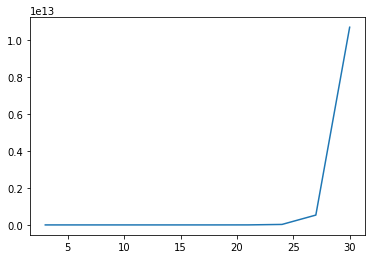

In [6]:
import numpy as np
x = np.arange(3, 31, 3)
y = np.exp(x)
fig1, ax1 = plt.subplots()
ax1.plot(x, y)

In [74]:
from gensim.utils import is_corpus
corpus = [(1, 1.0)]
corpus_or_not, corpus = is_corpus(corpus)
corpus_or_not

False